### Sample solution for experimentation and uplift testing task
#### The following solution is an example solution and not the only solution as the case study is open-ended.
### Load required libraries and datasets

In [1]:
%config Mode.auto_convert = False

In [2]:
# Load required libraries and datasets
#%% Import library
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import warnings
from scipy.stats import zscore
warnings.filterwarnings('ignore')
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs

qvi_data=pd.read_csv("E:/Vitual Internship/Quantium_Task2/Data/QVI_data.csv")
qvi_data.head(5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


### Select control stores
#### The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
#### stores that are operational for the entire observation period.
#### We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :
#### • Monthly overall sales revenue
#### • Monthly number of customers
#### • Monthly number of transactions per customer
#### Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [3]:
#### Calculate these measures over time for each store
## Create monthID column with format yyyymm
qvi_data['MONTHID'] = pd.to_datetime(qvi_data['DATE']).dt.strftime('%Y-%m')

# Chuyển đổi định dạng của cột "monthID" sang "yyyymm"
qvi_data['MONTHID'] = pd.to_datetime(qvi_data['MONTHID']).dt.strftime('%Y%m')
qvi_data['MONTHID']
#### Define the measure calculations
measureOverTime = qvi_data.groupby(['STORE_NBR', 'MONTHID']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: len(x) / len(x.unique())),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / len(x)),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / x.count() / x.sum()),
).reset_index().sort_values(['STORE_NBR', 'MONTHID'])
measureOverTime

#### Filter to the pre-trial period and stores with full observation periods
# Tìm các cửa hàng có đầy đủ 12 tháng quan sát
storesWithFullObs = measureOverTime.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()
measureOverTime['MONTHID'] = measureOverTime['MONTHID'].astype(int)
# Lọc dữ liệu của giai đoạn pre-trial
preTrialMeasures = measureOverTime[((measureOverTime['MONTHID']) < 201902) & measureOverTime['STORE_NBR'].isin(storesWithFullObs)]
preTrialMeasures



,STORE_NBR,MONTHID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.00,1.192308,0.019231
1,1,201808,176.1,42,1.00,1.255814,0.023256
2,1,201809,278.8,59,1.00,1.209677,0.016129
3,1,201810,188.1,44,1.00,1.288889,0.022222
4,1,201811,192.6,46,1.00,1.212766,0.021277
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.00,1.972222,0.027778
3160,272,201810,430.6,44,1.02,1.941176,0.019608
3161,272,201811,376.2,41,1.00,1.933333,0.022222
3162,272,201812,403.9,47,1.00,1.893617,0.021277


#### Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.
#### Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [4]:
def calculateCorrelation(inputTable, metricCol, storeComparison):
    calcCorrTable = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    storeNumbers = inputTable['STORE_NBR'].unique()
    
    for i in storeNumbers:
        calculatedMeasure = pd.DataFrame({
            'Store1': [storeComparison],
            'Store2': [i],
            'corr_measure': [inputTable.loc[inputTable['STORE_NBR'] == storeComparison, metricCol].corr(
                inputTable.loc[inputTable['STORE_NBR'] == i, metricCol])]
        })
        
        calcCorrTable = pd.concat([calcCorrTable, calculatedMeasure])
    
    return calcCorrTable

#### Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.
#### Let’s write a function for this

In [5]:
#### Create a function to calculate a standardised magnitude distance for a↪ measure,
#### looping through each control store
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    calcDistTable = pd.DataFrame({'Store1': [], 'Store2': [], 'MONTHID': [], 'measure': []})
    storeNumbers = inputTable['STORE_NBR'].unique()
    
    for i in storeNumbers:
        calculatedMeasure = pd.DataFrame({'Store1': [storeComparison] * len(inputTable[inputTable['STORE_NBR']==storeComparison]['MONTHID']),
                                       'Store2': [i] * len(inputTable[inputTable['STORE_NBR']==storeComparison]['MONTHID']),
                                       'MONTHID': inputTable[inputTable['STORE_NBR']==storeComparison]['MONTHID'].values,
                                       'measure': np.abs(inputTable[inputTable['STORE_NBR']==storeComparison][metricCol].values - inputTable[inputTable['STORE_NBR']==i][metricCol].values)})
        if len(calculatedMeasure) > 0:
            calcDistTable = pd.concat([calcDistTable, calculatedMeasure])
#             calcDistTable = pd.concat([calcDistTable, calculatedMeasure], ignore_index=True)
    
    # Standardise the magnitude distance so that the measure ranges from 0 to 1
    minMaxDist = calcDistTable.groupby(['Store1', 'MONTHID'])['measure'].agg(['min', 'max']).reset_index()
    minMaxDist.columns = ['Store1', 'MONTHID', 'minDist', 'maxDist']
    distTable = pd.merge(calcDistTable, minMaxDist, on=['Store1', 'MONTHID'])
    distTable['magnitudeMeasure'] = 1 - (distTable['measure'] - distTable['minDist']) / (distTable['maxDist'] - distTable['minDist'])
    finalDistTable = distTable.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    finalDistTable.columns = ['Store1', 'Store2', 'mag_measure']
    
    return finalDistTable

#### Now let’s use the functions to find the control stores! We’ll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [6]:
# Use the functions for calculating correlation
trial_store = 77
corr_nSales = calculateCorrelation(preTrialMeasures, "totSales", trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, "nCustomers", trial_store)

# Use the functions for calculating magnitude
magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, "totSales", trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, "nCustomers", trial_store)

#### We’ll need to combine the all the scores calculated using our function to create a composite score to rank on.
#### Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [7]:
# Create a combined score composed of correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

#### Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average

In [8]:
#### Combine scores across the drivers
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])
score_Control["finalControlScore"] = score_Control["scoreNSales"] * 0.5 + score_Control["scoreNCust"] * 0.5

#### The store with the highest score is then selected as the control store since it is most similar to the trial store
#### Select control stores based on the highest matching store (closest to 1 but not the store itself, i.e. the second ranked highest store)


In [14]:
#### Select control store for trial store 77
control_store = score_Control[score_Control.Store1 == trial_store].sort_values(by=['finalControlScore'], ascending=False).iloc[1]['Store2']
print(control_store)
print(sns.__version__)

1
0.12.2


#### Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.
#### We’ll look at total sales first.

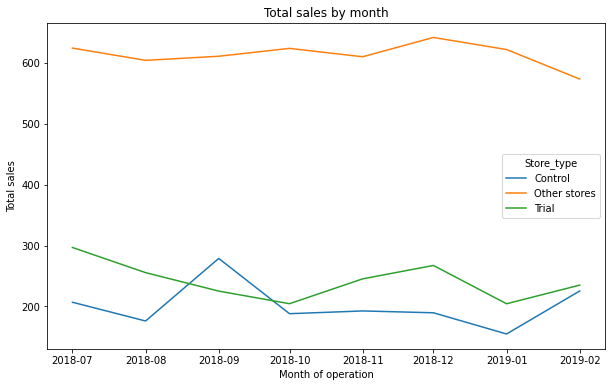

In [10]:
measureOverTimeSales = measureOverTime
measureOverTimeSales['Store_type'] = np.where(measureOverTimeSales['STORE_NBR'] == trial_store, 'Trial', np.where(measureOverTimeSales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
pastSales = measureOverTimeSales.groupby(['MONTHID', 'Store_type']).agg({'totSales':'mean'}).reset_index()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTHID'], format='%Y%m')
pastSales = pastSales[pastSales['MONTHID'] < 201903]
plt.figure(figsize=(10, 6))
sns.lineplot( x='TransactionMonth', y='totSales', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.show()

#### Next, number of customers

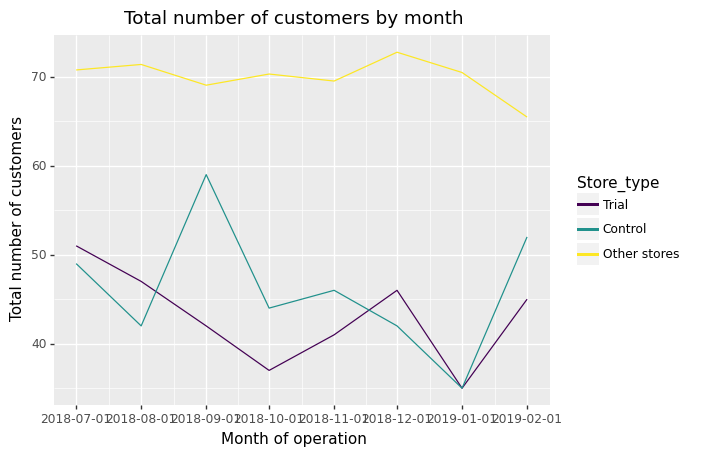

<ggplot: (83639766399)>

In [12]:
# Visual checks on trends based on the drivers
measureOverTimeCusts = measureOverTime.copy()
pastCustomers = (measureOverTimeCusts.assign(Store_type = lambda x: 
                        np.where(x['STORE_NBR'] == trial_store, 'Trial',
                                 np.where(x['STORE_NBR'] == control_store, 'Control', 'Other stores')))
                      .groupby(['MONTHID', 'Store_type'])
                      .agg(numberCustomers=('nCustomers', 'mean'))
                      .reset_index()
                      .assign(TransactionMonth = lambda x: pd.to_datetime(x['MONTHID'], format='%Y%m'),
                              Store_type = lambda x: pd.Categorical(x['Store_type'], categories=['Trial', 'Control', 'Other stores'], ordered=True))
                      .query('MONTHID < 201903'))

ggplot(pastCustomers, aes(x='TransactionMonth', y='numberCustomers', color='Store_type')) \
    + geom_line() \
    + labs(x='Month of operation', y='Total number of customers', title='Total number of customers by month')


### Assessment of trial
#####  The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.
#####  We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

In [16]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales = preTrialMeasures[(preTrialMeasures['STORE_NBR'] == trial_store) & (preTrialMeasures['MONTHID'] < 201902)]['totSales'].sum() / preTrialMeasures[(preTrialMeasures['STORE_NBR'] == control_store) & (preTrialMeasures['MONTHID'] < 201902)]['totSales'].sum()

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
scaledControlSales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store].assign(controlSales = lambda x: x['totSales'] * scalingFactorForControlSales)

#### Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period

In [18]:
# Calculate the percentage difference between scaled control sales and trial sales
scaledControlSalesSubset = scaledControlSales.loc[:, ["MONTHID", "controlSales"]]
trialSalesSubset = measureOverTime.loc[(measureOverTime['STORE_NBR'] == trial_store), ["MONTHID", "totSales"]]
percentageDiff = pd.merge(scaledControlSalesSubset, trialSalesSubset, on="MONTHID")
percentageDiff["percentageDiff"] = abs(percentageDiff["controlSales"] - percentageDiff["totSales"]) / percentageDiff["controlSales"]

#### Let’s see if the difference is significant

In [21]:
# As our null hypothesis is that the trial period is the same as the pre-trial period, 
# let's take the standard deviation based on the scaled percentage difference in the pre-trial period
preTrialPeriod = percentageDiff[percentageDiff['MONTHID'] < 201902]
stdDev = np.std(preTrialPeriod['percentageDiff'])

# Note that there are 8 months in the pre-trial period
# hence 8 - 1 = 7 degrees of freedom
degreesOfFreedom = 7

# We will test with a null hypothesis of there being 0 difference between trial and control stores
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['MONTHID'].astype(str), format='%Y%m')
result = percentageDiff[(percentageDiff['MONTHID'] > 201901) & (percentageDiff['MONTHID'] < 201905)]
result = result.loc[:, ["TransactionMonth", "tValue"]]
result

,TransactionMonth,tValue
7,2019-02-01,1.655607
8,2019-03-01,1.984796
9,2019-04-01,1.279147


In [23]:
from scipy.stats import t

# Find the 95th percentile of the t distribution with the appropriate degrees of freedom
p_value = 1 - t.cdf(2.306, df=7) # assuming a two-tailed test with alpha=0.05
p_value

0.027253535226059

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_2612/3013933247.py, line 25)

IndexError: invalid index to scalar variable.

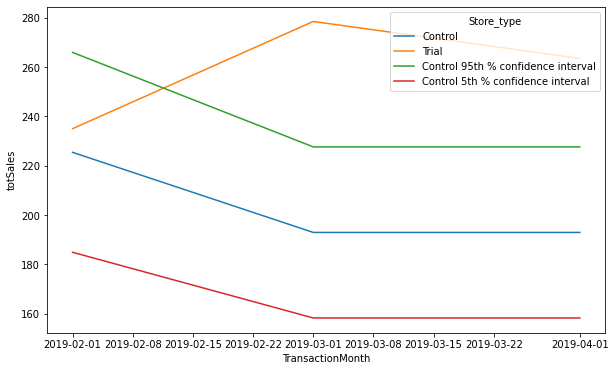

In [57]:
# Copy measureOverTime to measureOverTimeSales
measureOverTimeSales = measureOverTime.copy()

# Trial and control store total sales
pastSales = (measureOverTimeSales.assign(Store_type=np.where(measureOverTimeSales['STORE_NBR']==trial_store, "Trial",
                                                             np.where(measureOverTimeSales['STORE_NBR']==control_store, "Control", "Other stores")))
             .groupby(['MONTHID', 'Store_type'])
             .agg({'totSales': 'mean'})
             .reset_index())

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTHID'], format='%Y%m')

pastSales = pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type']=='Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type']=='Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5], ignore_index=True)

# Filter the data by year and month
trialAssessment = trialAssessment[(trialAssessment["MONTHID"] < 201905) &
                                  (trialAssessment["MONTHID"] > 201901)]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x="TransactionMonth", y="totSales", hue="Store_type")
plt.fill_between(x=[min(trialAssessment["TransactionMonth"]), max(trialAssessment["TransactionMonth"])], y1=0, y2=float("inf"), alpha=0.1)
plt.title("Total sales by month")

#### The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.
#### Let’s have a look at assessing this for number of customers as well.

In [59]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust = (preTrialMeasures[(preTrialMeasures["STORE_NBR"] == trial_store) & 
                                                (preTrialMeasures["MONTHID"] < 201902)]
                              ["nCustomers"].sum() /
                              preTrialMeasures[(preTrialMeasures["STORE_NBR"] == control_store) & 
                                                (preTrialMeasures["MONTHID"] < 201902)]
                              ["nCustomers"].sum())

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
scaledControlCustomers = (measureOverTimeCusts[(measureOverTimeCusts["STORE_NBR"] == control_store)]
                          .assign(controlCustomers=lambda x: x["nCustomers"] * scalingFactorForControlCust)
                          .assign(Store_type=lambda x: np.where(x["STORE_NBR"] == trial_store, "Trial", 
                                                                 np.where(x["STORE_NBR"] == control_store, 
                                                                          "Control", "Other stores")))
                          [["MONTHID", "controlCustomers", "Store_type"]])

# Calculate the percentage difference between scaled control sales and trial sales
percentageDiff = (pd.merge(scaledControlCustomers[["MONTHID", "controlCustomers"]],
                           measureOverTimeCusts[(measureOverTimeCusts["STORE_NBR"] == trial_store)][["nCustomers", "MONTHID"]],
                           on="MONTHID")
                  .assign(percentageDiff=lambda x: abs(x["controlCustomers"] - x["nCustomers"]) / x["controlCustomers"]))


#### Let’s again see if the difference is significant visually!

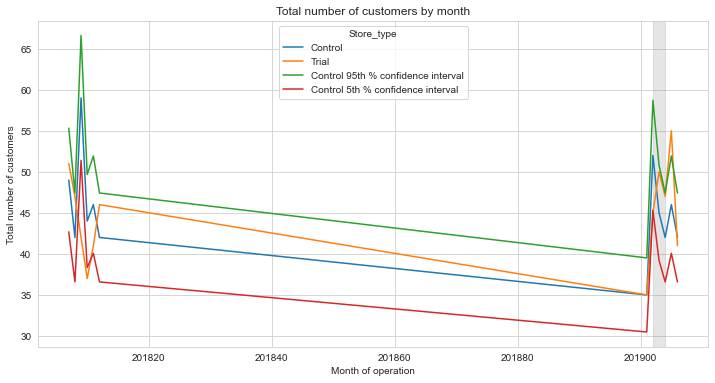

In [61]:
#### As our null hypothesis is that the trial period is the same as the
# pre‐trial period, let's take the standard deviation based on the scaled
# percentage difference in the pre‐trial period
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate standard deviation
stdDev = np.std(percentageDiff[percentageDiff['MONTHID'] < 201902]['percentageDiff'])

# Set degrees of freedom
degreesOfFreedom = 7

# Trial and control store number of customers
pastCustomers = measureOverTimeCusts.groupby(['MONTHID', 'Store_type'], as_index=False).agg({'nCustomers': 'mean'})
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Merge dataframes
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5], axis=0)

# Plot graph
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=trialAssessment, x="MONTHID", y="nCustomers", hue="Store_type")
ax.set(xlabel='Month of operation', ylabel='Total number of customers', 
       title='Total number of customers by month')
ax.axvspan(trialAssessment.loc[(trialAssessment['MONTHID'] > 201901) & (trialAssessment['MONTHID'] < 201905), 'MONTHID'].min(),
           trialAssessment.loc[(trialAssessment['MONTHID'] > 201901) & (trialAssessment['MONTHID'] < 201905), 'MONTHID'].max(),
           alpha=0.2, color='grey')
plt.show()


#### We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.
